In [34]:
import torch
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print(torch.__version__)
print(torch.cuda.is_available())

1.8.1+cu101
True


## 读取数据集

In [35]:
data = pd.read_csv(filepath_or_buffer="../小型CSV数据/iris.csv")
data

,Unnamed: 0,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,1,5.1,3.5,1.4,0.2,setosa
1,2,4.9,3.0,1.4,0.2,setosa
2,3,4.7,3.2,1.3,0.2,setosa
3,4,4.6,3.1,1.5,0.2,setosa
4,5,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,virginica
146,147,6.3,2.5,5.0,1.9,virginica
147,148,6.5,3.0,5.2,2.0,virginica
148,149,6.2,3.4,5.4,2.3,virginica


In [36]:
data.Species.unique() # 类别标签为3

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [37]:
# pd.factorize()做的也是“因式分解”，把常见的字符型变量分解为数字
# https://blog.csdn.net/ssswill/article/details/86555935
# https://www.jianshu.com/p/78d34e4ea83f
# pd.factorize()得到的是一个元祖，元祖的第一个元素为转换为了数字的标签，第二个元素为原始的字符型标签
data.Species = pd.factorize(data.Species)[0]
# 也可以下面写法：
# data["Species"] = pd.factorize(data.Species)[0]

In [38]:
data

,Unnamed: 0,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,1,5.1,3.5,1.4,0.2,0
1,2,4.9,3.0,1.4,0.2,0
2,3,4.7,3.2,1.3,0.2,0
3,4,4.6,3.1,1.5,0.2,0
4,5,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,2
146,147,6.3,2.5,5.0,1.9,2
147,148,6.5,3.0,5.2,2.0,2
148,149,6.2,3.4,5.4,2.3,2


In [39]:
X = data.iloc[:, 1:-1].values # values将其转换为ndarray数据格式
X.shape

(150, 4)

In [40]:
Y = data.iloc[:, -1].values
Y.shape

(150,)

In [41]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X, Y)

train_x = torch.from_numpy(train_x).type(torch.float32)
train_y = torch.from_numpy(train_y).type(torch.int64)
test_x = torch.from_numpy(test_x).type(torch.float32)
test_y = torch.from_numpy(test_y).type(torch.int64)

In [42]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 8

# 使用DataLoader装载数据
train_dataset = TensorDataset(train_x, train_y)
traindata_loader = DataLoader(dataset=train_dataset, 
                              batch_size=batch_size,
                              shuffle=True)
test_dataset = TensorDataset(test_x, test_y)
testdata_loader = DataLoader(dataset=test_dataset, 
                             batch_size=batch_size)

## 创建模型

In [43]:
import torch.nn.functional as F

class Model(torch.nn.Module):
    def __init__(self):
        # 继承父类中所有的属性
        super().__init__()
        self.linear_1 = torch.nn.Linear(in_features=X.shape[-1], out_features=32)
        self.linear_2 = torch.nn.Linear(in_features=32, out_features=32)
        self.linear_3 = torch.nn.Linear(in_features=32, out_features=3)

    def forward(self, input): # 覆盖重写父类中的该方法
        x = F.relu(self.linear_1(input))
        x = F.relu(self.linear_2(x))
        x = self.linear_3(x)
        return x

In [44]:
learning_rate = 0.001

def get_model():
    model = Model()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    return model, optimizer

model, optimizer = get_model()

In [45]:
# https://blog.csdn.net/Zzz_zhongqing/article/details/107185468
# 当二分类问题的输出层不激活的时候，也是可以使用CrossEntropyLoss的；如果要经过sigmoid的话则使用BCELOSS
# 另外需要注意的是，对于多分类问题，其label的形式为one-hot形式的时候，使用torch.nn.NLLLoss()，此时输出层的激活方式为torch.log_softmax
loss_func = torch.nn.CrossEntropyLoss()
epochs = 50

In [13]:
# 提前查看一下
input_batch, label_batch = next(iter(traindata_loader))
input_batch.shape, label_batch.shape

(torch.Size([8, 4]), torch.Size([8]))

In [14]:
y_pred = model(input_batch)
# y_pred.shape
torch.argmax(y_pred, dim=1)

tensor([0, 0, 0, 0, 0, 0, 0, 0])

## 创建训练函数

In [15]:
# 定义计算正确率的函数
def accuracy(y_pred, y_true):
    y_pred = torch.argmax(y_pred, dim=1)
    acc = (y_pred == y_true).float().mean()
    return acc

In [16]:
train_loss = []
train_accuracy = []
test_loss_ = []
test_accuracy_ = []

In [17]:
for epoch in range(epochs):
    for x, y in traindata_loader:
        y_pred = model(x)
        loss = loss_func(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        epoch_accuracy = accuracy(model(train_x), train_y)
        epoch_loss = loss_func(model(train_x), train_y).data.item()

        test_accuracy = accuracy(model(test_x), test_y)
        test_loss = loss_func(model(test_x), test_y).data.item()
        print("epoch = ", epoch, 
              "loss = ", round(epoch_loss, 3), 
              "accuracy = ", round(epoch_accuracy.item(), 3),              
              "test_loss = ", round(test_loss, 3),
              "test_accuracy = ", round(test_accuracy.item(), 3))
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_accuracy)
        test_loss_.append(test_loss)
        test_accuracy_.append(test_accuracy)

epoch =  0 loss =  1.074 accuracy =  0.312 test_loss =  1.034 test_accuracy =  0.395
epoch =  1 loss =  0.964 accuracy =  0.661 test_loss =  0.954 test_accuracy =  0.684
epoch =  2 loss =  0.887 accuracy =  0.661 test_loss =  0.885 test_accuracy =  0.684
epoch =  3 loss =  0.796 accuracy =  0.661 test_loss =  0.775 test_accuracy =  0.684
epoch =  4 loss =  0.716 accuracy =  0.661 test_loss =  0.686 test_accuracy =  0.684
epoch =  5 loss =  0.646 accuracy =  0.661 test_loss =  0.607 test_accuracy =  0.684
epoch =  6 loss =  0.59 accuracy =  0.67 test_loss =  0.543 test_accuracy =  0.711
epoch =  7 loss =  0.547 accuracy =  0.67 test_loss =  0.496 test_accuracy =  0.684
epoch =  8 loss =  0.514 accuracy =  0.688 test_loss =  0.457 test_accuracy =  0.737
epoch =  9 loss =  0.486 accuracy =  0.777 test_loss =  0.424 test_accuracy =  0.921
epoch =  10 loss =  0.461 accuracy =  0.83 test_loss =  0.395 test_accuracy =  0.974
epoch =  11 loss =  0.439 accuracy =  0.902 test_loss =  0.372 test_

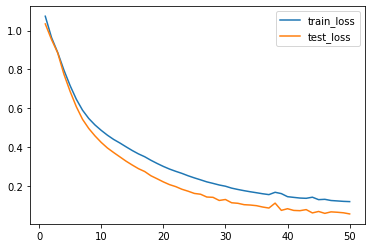

In [30]:
plt.plot(range(1, epochs+1), train_loss, label="train_loss")
plt.plot(range(1, epochs+1), test_loss_, label="test_loss")
plt.legend()

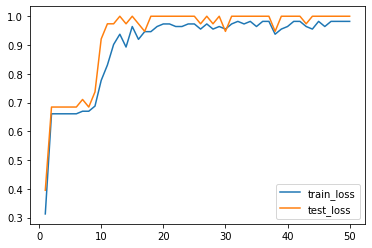

In [32]:
plt.plot(range(1, epochs+1), train_accuracy, label="train_loss")
plt.plot(range(1, epochs+1), test_accuracy_, label="test_loss")
plt.legend()

## 编写通用的训练函数

In [56]:
def fit(model, traindata_loader, testdata_loader, epoch):
    pred_corrected_num = 0
    total_num = 0
    training_batch_loss = 0
    for x, y in traindata_loader:
        y_pred = model(x)
        loss = loss_func(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            pred_corrected_num += (y_pred == y).sum().item()
            total_num += y.shape[0]
            training_batch_loss += loss.item()
    epoch_accuracy = pred_corrected_num / total_num
    epoch_loss = training_batch_loss / len(traindata_loader.dataset)
    #---------------------------------------------------------------
    test_pred_corrected_num = 0
    test_total_num = 0
    test_batch_loss = 0
    with torch.no_grad():
        for x, y in testdata_loader:
            y_pred = model(x)
            loss = loss_func(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_pred_corrected_num += (y_pred == y).sum().item()
            test_total_num += y.shape[0]
            test_batch_loss += loss.item()
    test_accuracy = test_pred_corrected_num / test_total_num
    test_loss = test_batch_loss / len(testdata_loader.dataset)
    #---------------------------------------------------------------
    print("epoch = ", epoch, 
        "loss = ", round(epoch_loss, 3), 
        "accuracy = ", round(epoch_accuracy, 3),              
        "test_loss = ", round(test_loss, 3),
        "test_accuracy = ", round(test_accuracy, 3))
    return epoch_loss, epoch_accuracy, test_loss, test_accuracy

In [57]:
model, optimizer = get_model()

In [58]:
for epoch in range(epochs):
    epoch_loss, epoch_accuracy, test_loss, test_accuracy = fit(model, traindata_loader,
                                                               testdata_loader, epoch)
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    test_loss_.append(test_loss)
    test_accuracy_.append(test_accuracy)

epoch =  0 loss =  0.131 accuracy =  0.464 test_loss =  0.13 test_accuracy =  0.737
epoch =  1 loss =  0.122 accuracy =  0.634 test_loss =  0.12 test_accuracy =  0.737
epoch =  2 loss =  0.115 accuracy =  0.643 test_loss =  0.112 test_accuracy =  0.737
epoch =  3 loss =  0.106 accuracy =  0.777 test_loss =  0.101 test_accuracy =  0.974
epoch =  4 loss =  0.096 accuracy =  0.938 test_loss =  0.089 test_accuracy =  0.947
epoch =  5 loss =  0.085 accuracy =  0.884 test_loss =  0.078 test_accuracy =  0.842
epoch =  6 loss =  0.077 accuracy =  0.866 test_loss =  0.068 test_accuracy =  0.947
epoch =  7 loss =  0.069 accuracy =  0.848 test_loss =  0.061 test_accuracy =  0.895
epoch =  8 loss =  0.063 accuracy =  0.884 test_loss =  0.057 test_accuracy =  0.868
epoch =  9 loss =  0.059 accuracy =  0.902 test_loss =  0.052 test_accuracy =  0.947
epoch =  10 loss =  0.056 accuracy =  0.812 test_loss =  0.049 test_accuracy =  0.947
epoch =  11 loss =  0.051 accuracy =  0.946 test_loss =  0.046 tes